## Семинар 10: "Генерация текстов"

ФИО: Дорожинский Владислав Игоревич

In [440]:
import numpy as np
import re
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys

%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
!head -n 2 author-quote.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [4]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

In [5]:
m = map(len, lines)

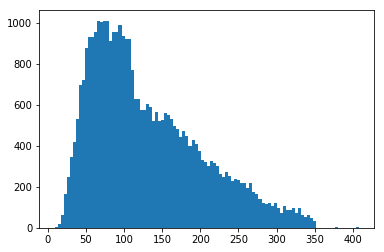

In [6]:
plt.hist(list(map(len, lines)), bins=100);

In [7]:
line = lines[0]

In [8]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [9]:
lines = list(filter(lambda x: len(x) <= 50, lines))

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [97]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [98]:
dataset = Quotes(lines, vocab)

In [367]:
def collate(a):
    X = np.empty(len(a), dtype=np.object)
    Y = np.empty(len(a), dtype=np.object)
    for i, (x, y) in enumerate(a):
        X[i] = x
        Y[i] = y
    return X, Y

dataloader = DataLoader(dataset, shuffle=True, batch_size=128, collate_fn=collate)

### Часть 2: определение модели

In [368]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embeddings = [self.embedding(e) for e in input]
        bs = len(input)
        seq = pack_sequence(embeddings)
        h = Variable(torch.Tensor(self.layers, bs, self.hidden_size).normal_(), requires_grad=False)*0
        output, _ = self.generator(seq, h.cuda())
        output, lengths = pad_packed_sequence(output)
        max_len = len(input[0])
        classes = self.classifier(output.view(bs*max_len, -1)).view(max_len, bs, -1)
        mask = torch.zeros((max_len, bs, 1)).cuda()
        for i in range(bs):
            mask[0:lengths[i],i] = 1
        classes = classes * mask
        return classes, lengths
    
    def generate(self, vocab, max_len=100, T=1.0):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True).cuda()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, h.cuda())
            classes = self.classifier(output[0])
            probs = classes.data.cpu().numpy().reshape(-1) / T
            probs = np.exp(probs - np.max(probs)) / np.sum(np.exp(probs - np.max(probs)))
            new_token_id = np.random.choice(probs.shape[0], size=1, p=probs)[0]
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [459]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=128, layers=2).cuda()

### Часть 3: обучение модели

In [460]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01, betas=(0, 0.9))
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)

In [461]:
criterion = nn.CrossEntropyLoss()

In [462]:
losses = []

In [463]:
n_epochs = 200
for epoch in range(n_epochs):
    losses = []
    for i, (x, y) in enumerate(dataloader):
        lengths = [len(s) for s in x]
        order = np.argsort(lengths)[::-1]
        x = x[order]
        y = y[order]
        x = [Variable(torch.tensor(s)).cuda() for s in x]
        y = [Variable(torch.tensor(s)).cuda() for s in y]
        y = pad_packed_sequence(pack_sequence(y))[0].view(-1)
        
        prediction, lengths = oracle(x)
        loss = criterion(prediction.view(-1, vocab.size), y)
        loss.backward()
        optimizer.step()
        oracle.zero_grad()
        losses.append(loss.item())
    scheduler.step(np.mean(losses))
    if epoch % 4 == 0:
        print('{} / {}:'.format(epoch, n_epochs), np.mean(losses), oracle.generate(vocab, T=0.5))

/home/user/Documents/MachineLearning/mlenv/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


0 / 200: 3.123282786073356 A maythe Wor is the is the papthe are mary is the athe hathe sors is norathe ther ofare.<eos>
4 / 200: 2.2033673237110007 Chore Lishion is the streat with is the historion is the reverest of the you word.<eos>
8 / 200: 2.0356811737192086 I am fool many for ever to be a contrack.<eos>
12 / 200: 1.9402615982910683 I have not like rid for the money.<eos>
16 / 200: 1.8926346836418941 I do in Grood a progress and the Jappier.<eos>
20 / 200: 1.8480717025954148 I like that change is a big puts it is the life.<eos>
24 / 200: 1.8250803207529003 I love song is a power my soot for of ideal that prove for everything.<eos>
28 / 200: 1.8158446262622703 What we are some gone should be.<eos>
32 / 200: 1.8076709508895874 By past should eat to lose who are not fruings.<eos>
36 / 200: 1.8052310203683788 The first did, I try to love by accident.<eos>
40 / 200: 1.7986955067207073 I've always been on my delader.<eos>
44 / 200: 1.8058188126004975 I'm free free prockencieled in the 

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [466]:
import warnings
warnings.filterwarnings('ignore')

In [496]:
oracle.generate(vocab, T=1.0)

'It is impossible to love and married, by win.<eos>'

In [513]:
oracle.generate(vocab, T=0.5)

'The greatest gift in life is to seell mind.<eos>'

In [524]:
oracle.generate(vocab, T=0.5)

"I'm not gonna be a person, not for it.<eos>"

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: